<a href="https://colab.research.google.com/github/porter7678/image_caption_generator/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###To Do:
 - Get my model to learn better


###Fix in the future:
 - Experiment with learning rate
 - If I can get the model training on just one caption, is there some way to generalize the loss to account for all 5 captions that I have? Like treat the loss as the lowest out of all 5 captions?
 - Use all 5 captions instead of just 1
 - Get it to work for batch size more than 1
 - Shuffle my dataloader
 - Size images back up
 - I did 'drop_last' on my dataloaders, there is a chance I don't want to do that
 - Use a different CNN
 - After getting something running, try to strip it down to just what the paper had (including a CNN from that year)
 - Mess with the dimensions of layers within the DenseNet to make it work better.
 - Use the raw Negative Log Likelihood for loss instead of CrossEntropy
 - Implement the LSTM from the paper

###Possible improvements:
 - Different CNN
 - Implement Attention
 - Fix the embedding dictionary
 - Teacher forcing (I actually am doing this)
 - Beam search
 - Add a temperature parameter to my evaluation sampling

###Questions
 - What does pin_memory in the DataLoader do?
 - What does .train() and .eval() do?
 - How do PyTorch batches work?
 - Should I have two different optimizers for my two different models? 


 ----------------------------------------------


![](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

# Imports

In [0]:
# !pip install torch 
# !pip install torchvision
# !pip install tqdm
# !pip install kaggle

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets, models
from tqdm import tqdm
import os

assert torch.cuda.is_available()

# Data Preparation

In [0]:
os.environ['KAGGLE_USERNAME'] = 'porter7678'
if not 'KAGGLE_KEY' in os.environ:
  os.environ['KAGGLE_KEY'] = input()

In [4]:
# Takes ~70 secs
!kaggle datasets download -d ming666/flicker8k-dataset
!unzip -q flicker8k-dataset.zip

# Discard extra directories
! rm -rf flickr8k_dataset/
! rm -rf flickr8k_text/
! rm -rf sample_data/

# Create Train and Valid directories
os.mkdir('Flickr8k_Dataset/Train_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid')
os.replace('Flickr8k_Dataset/Flicker8k_Dataset', 'Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train')

 99% 2.06G/2.08G [00:13<00:00, 183MB/s]
100% 2.08G/2.08G [00:13<00:00, 165MB/s]


In [0]:
############ - DATATSET README - ################################################################
# Flickr8k.token.txt - the raw captions of the Flickr8k Dataset,
#       the first column is the ID of the caption which is "image address # caption number"
# Flickr8k.lemma.txt - the lemmatized version of the above captions 
# Flickr_8k.trainImages.txt - The list of training images used in our experiments
# Flickr_8k.devImages.txt - The list of development/validation images used in our experiments
# Flickr_8k.testImages.txt - The list of test images used in our experiments
#################################################################################################
# 8091 images

In [0]:
# Create list of images to move to validation folder
valid_img_names = []
file_names = ['Flickr8k_text/Flickr_8k.devImages.txt', 'Flickr8k_text/Flickr_8k.testImages.txt']
for file_name in file_names:
    with open(file_name, 'r') as f:
        for line in f.readlines():
            valid_img_names.append(line.strip())

# Move validation images to validation folder
for file_name in valid_img_names:
    os.replace('Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train/' + file_name, 'Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid/' + file_name)

# Dataset Implementation

In [0]:
class ImageCaptionDataset(Dataset):
    '''Dataset class containing images and captions

    Attributes:
        image_folder (ImageFolder Dataset): Images to be captioned (data)
        caption_folder (list): Captions associated with images for validation (labels)
    '''
    def __init__(self, train=True, img_size=128):
        # Initialize with training images or validation images depending on train parameter
        folder_prefix = 'Train' if train else 'Valid'
        folder_path = 'Flickr8k_Dataset/' + folder_prefix + '_Images'
        self.image_folder = datasets.ImageFolder(root=folder_path,
                                                transform=transforms.Compose([
                                                    transforms.Resize(img_size),
                                                    # transforms.CenterCrop(img_size),  # This makes images square
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                ]))
        
        train_img_captions = []
        valid_img_captions = []
        curr_img_captions = []

        with open('Flickr8k_text/Flickr8k.token.txt', 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            line = line.strip().split('\t')
            curr_img_captions.append(line[1])

            # Each image has five captions, so start a new caption list each 5 iterations
            if i % 5 == 4:
                img_name = line[0][:-2]
                if img_name in valid_img_names:
                    valid_img_captions.append((img_name, curr_img_captions))
                else:
                    train_img_captions.append((img_name, curr_img_captions))
                curr_img_captions = []

        # Data cleaning: This is an extra caption in the dataset with no image
        train_img_captions.pop(1010)

        self.caption_folder = train_img_captions if train else valid_img_captions

    
    def __getitem__(self, index):
        img = self.image_folder[index]
        captions = self.caption_folder[index]
        return img[0], captions[1][0]  # For now, I'm only taking the first of 5 captions for each image
        

    def __len__(self):
        return len(self.caption_folder)

# Models

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size=128):
        super(EncoderCNN, self).__init__()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Linear(1024, 1024)
        self.embed = nn.Linear(1024, embed_size)
        self.relu = nn.ReLU()

    def forward(self, images):
        outputs = self.relu(self.densenet(images))
        embeddings = self.embed(outputs)
        return embeddings

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_word, hidden_state, cell_state, is_caption=True):
        if is_caption:
            embedding = self.embedding(input_word)
        else:
            embedding = input_word     # This is for when we pass the image in first
        embed = F.relu(embedding)
        embed = embed.view(1, 1, -1)

        output, (hidden, cell) = self.lstm(embed, (hidden_state, cell_state))
        scores = self.out(output[0])

        return scores, hidden, cell

    def init_hidden(self):
        return torch.zeros((1, 1, self.hidden_size))  # NOTE: I may need to change this 1 to batch size later

# Helper Functions

In [0]:
def show_imgs(x, new_fig=True):
    '''Displays the image contained in a tensor.

    Arguments:
        x ((c,m,n) tensor): The image to be shown
    '''
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [0]:
def create_corpus_dictionary(train_dataset, valid_dataset):
    '''Creates corpus dictionary
    
    Arguments:
        train_dataset (ImageCaptionDataset): training dataset
        valid_dataset (ImageCaptionDataset): validation dataset
        
    Returns:
        caption_dictionary (list): all words in any caption (non-case sensitive), and start/end tokens
        '''
    # Get a dictionary going for my captions
    caption_dictionary = []
    max_caption_len = 0

    for caption_list in train_dataset.caption_folder:
        for caption in caption_list[1]:
            caption = caption.split()
            if len(caption) > max_caption_len:
                max_caption_len = len(caption)
            for word in caption:
                word = word.lower()
                if word not in caption_dictionary:
                    caption_dictionary.append(word)

    for caption_list in valid_dataset.caption_folder:
        for caption in caption_list[1]:
            caption = caption.split()
            if len(caption) > max_caption_len:
                max_caption_len = len(caption)
            for word in caption:
                word = word.lower()
                if word not in caption_dictionary:
                    caption_dictionary.append(word)

    caption_dictionary.append('<SOS>')
    caption_dictionary.append('<EOS>')

    return caption_dictionary

In [0]:
def get_word_tensor(caption):
    '''Convert caption into tensor with corresponding dictionary indices'''
    word_tensor = torch.zeros(len(caption))
    for i, word in enumerate(caption):
        word_tensor[i] = caption_dictionary.index(word)
    return word_tensor
        

def get_caption_tensors(caption):
    '''Convert caption into input and target tensors'''
    words = caption.lower().split()
    # Append start and stop tokens
    inp = ['<SOS>'] + words
    target = words + ['<EOS>']

    # Convert to tensor
    inp = get_word_tensor(inp)
    target = get_word_tensor(target)
    return inp, target


# Use 'torch.nn.utils.rnn.pad_sequence' to pad if necessary

# Training

In [13]:
n_epochs = 1
img_size = 256
hidden_size = 128  # Maybe experiment with this later?
batch_size = 1
lr = 1e-3
plot_every = 50

train_dataset = ImageCaptionDataset(train=True, img_size=img_size)
valid_dataset = ImageCaptionDataset(train=False, img_size=img_size)

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          pin_memory=True)

caption_dictionary = create_corpus_dictionary(train_dataset, valid_dataset)
vocab_size = len(caption_dictionary)

encoder = EncoderCNN(embed_size=img_size).cuda()
decoder = DecoderRNN(img_size, hidden_size, vocab_size).cuda()
# CrossEntropy takes raw scores as input, and compares them to a target index of classification class
criterion = nn.CrossEntropyLoss() 
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

losses = []
averaged_losses = []
valid_losses = []

loop = tqdm(total=len(train_loader) * n_epochs, position=0, leave=False)
for epoch in range(n_epochs):
    for batch, (x, captions) in enumerate(train_loader):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        batch_loss = 0

        # Get inp and label caption tensors
        y_inp, y_truth = get_caption_tensors(captions[0]) # NOTE: This isn't gonna work when my batch size isn't 1
        
        # Move onto GPU
        x = x.cuda()
        y_inp = y_inp.cuda()
        y_truth = y_truth.cuda()

        # Encode the image
        x_encoded = encoder(x)

        # Pass in image tensor
        hidden_initial = decoder.init_hidden().cuda()
        cell_initial = decoder.init_hidden().cuda()
        scores, hidden, cell = decoder(x_encoded, hidden_initial, cell_initial, is_caption=False)

        # Get a start_token to be the predicted output of the image on the first pass thru the RNN
        start_token_tensor = torch.Tensor([vocab_size - 2]).long().cuda()

        # Calculate loss on start token
        batch_loss += criterion(scores, start_token_tensor)

        # Pass in caption tensors
        y_truth = y_truth.long()
        for i, word in enumerate(y_inp):
            word = word.long()
            scores, hidden, cell = decoder(word, hidden, cell, is_caption=True)
            batch_loss += criterion(scores, y_truth[i].unsqueeze(0))

        batch_loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        losses.append(batch_loss.item())

        # Store the average loss for plotting
        if batch % plot_every == plot_every - 1:
            averaged_losses.append([batch, sum(losses) / plot_every])
            losses = []

        loop.set_description('epoch{}, loss:{:.4f} '.format(epoch, batch_loss))
        loop.update(1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 120MB/s]
epoch0, loss:40.4592 : 100%|██████████| 6091/6091 [20:34<00:00,  4.84it/s]

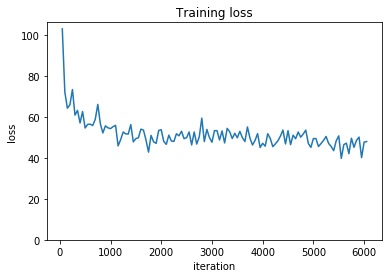

In [55]:
# Plot the average loss
avg_losses = np.array(averaged_losses)
batch = avg_losses[:,0]
plot_loss = avg_losses[:,1]
plt.plot(batch, plot_loss)
plt.ylim(bottom=0)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()

# Generate Output

TARGET:	 A man in a wetsuit is throwing a baby wearing a wetsuit up into the air .
OUTPUT:	 <SOS> a group of catching people are talking in front of the water . <EOS>


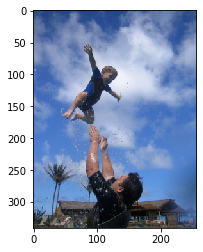

In [54]:
x, captions = valid_dataset[10]
show_imgs(x)
print('TARGET:\t', captions)

y_inp, y_truth = get_caption_tensors(captions[0]) # NOTE: This isn't gonna work when my batch size isn't 1
        
# Move onto GPU
x = x.cuda()
y_inp = y_inp.cuda()

# Encode the image
x_encoded = encoder(x.unsqueeze(0))

output_caption = ''

# Pass in image tensor
hidden_initial = decoder.init_hidden().cuda()
cell_initial = decoder.init_hidden().cuda()
scores, hidden, cell = decoder(x_encoded, hidden_initial, cell_initial, is_caption=False)

# Sample the first word
probabilities = torch.exp(scores)
sampled_index = torch.multinomial(probabilities, 1).squeeze().squeeze()
word = caption_dictionary[sampled_index]
output_caption += word + ' '

# Continue sampling words until we get an end token or the caption is too long
has_end_token = False
limit = 50
count = 0
while not has_end_token and count < limit:
    count += 1

    scores, hidden, cell = decoder(sampled_index, hidden, cell, is_caption=True)
    probabilities = torch.exp(scores)
    sampled_index = torch.multinomial(probabilities, 1).squeeze().squeeze()

    word = caption_dictionary[sampled_index]
    output_caption += word
    if word == '<EOS>':
        has_end_token = True
    else:
        output_caption += ' '   # Add a space if the caption isn't finished yet

print('OUTPUT:\t', output_caption)